## **Scream Detection Using CNN + LSTM**

In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
import pickle
import os
import librosa

from tqdm import tqdm
from earlystopping import EarlyStopping

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision
import torchvision.models as models

In [2]:
if torch.cuda.is_available()==True:
    device='cuda:0'
else:
    device='cpu'

print(device)
np.random.seed(112)
torch.manual_seed(112)

cuda:0


In [3]:
import gc

def clean():
    gc.collect()
    torch.cuda.empty_cache()

In [4]:
# set epochs and batch_size
EPOCHS = 300
BATCH_SIZE = 512

In [5]:
# set early stop setting
early_stopping = EarlyStopping(patience = 30, verbose = True)

In [6]:
# extract mfccs and sc, acr, rms for a given wav file.
# used in test session 
def extract_features(file_path):
    audio, sample_rate = librosa.load(path=file_path)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=16)
    
    sc = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    rms = librosa.feature.rms(y=audio)
    features = np.vstack((sc, zcr, rms))
    
    return mfccs, features

In [7]:
# set directories
class Config():
    training_df_dir = "./dataset/DataFinal2/train_w_features.pkl"
    test_df_dir = "./dataset/DataFinal2/test.csv"
    test_data_dir= "./dataset/DataFinal2/test/"

In [8]:
# data preview ( training data is pre-extracted )
df = pd.read_pickle(Config().training_df_dir)
df.head()

,file,label,mfccs,features
0,00001.wav,0,"[[-669.36633, -633.17426, -630.46625, -634.311...","[[1749.7470890266736, 1762.38937056839, 1743.8..."
1,00002.wav,0,"[[-676.54846, -644.3386, -646.3123, -651.2253,...","[[1636.2124629160744, 1590.7553609415274, 1737..."
2,00003.wav,0,"[[-622.53485, -593.8227, -588.59235, -587.1136...","[[2010.2357362790042, 1946.369032503802, 1922...."
3,00004.wav,0,"[[-895.66205, -894.86176, -895.16815, -894.194...","[[5250.292810582463, 5243.545691722471, 5236.8..."
4,00005.wav,0,"[[-586.84045, -557.59766, -554.48016, -549.502...","[[3440.69730404678, 3652.45197264897, 3594.313..."


### **Training**

In [9]:
class TrainingDataset(Dataset):
    def __init__(self, Config):
        self.df = pd.read_pickle(Config.training_df_dir)
        
    def __len__(self):
        return len(self.df.file)
    
    def __getitem__(self, idx):
        mfccs = torch.tensor(self.df.mfccs[idx]).to(torch.float32).unsqueeze(0)
        features = torch.tensor(self.df.features[idx]).to(torch.float32).unsqueeze(0)
        #data = torch.cat([mfccs, features], dim=-2).to(torch.float32)
        
        label = torch.tensor(self.df.label[idx]).unsqueeze(0)
        
        return mfccs, features, label

In [10]:
# train / valid dataset and dataloader setting
train_valid_dataset = TrainingDataset(Config())
train_dataset, valid_dataset = random_split(train_valid_dataset, [0.8, 0.2])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
# main model architecture
class CRNN_Model(nn.Module):
    def __init__(self):
        super(CRNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout2d(p=0.2)
        
        self.lstm = nn.LSTM(input_size=128*5, hidden_size=32, num_layers=2, dropout=0.2)
        
        self.linear1 = nn.Linear(32*44, 16)
        self.linear2 = nn.Linear(16, 1)
        self.sig = nn.Sigmoid()
        
        self.conv4 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
    def forward(self, mfccs, features):
        out1 = self.conv1(mfccs)
        out1 = self.relu(out1)
        out1 = self.maxpool1(out1)
        out1 = self.conv2(out1)
        out1 = self.relu(out1)
        out1 = self.maxpool2(out1)
        out1 = self.conv3(out1)
        out1 = self.relu(out1)
        out1 = self.maxpool3(out1)
        out1 = self.dropout(out1)
        
        out2 = self.conv4(features)
        out2 = self.relu(out2)
        out2 = self.conv5(out2)
        out2 = self.relu(out2)
        out2 = self.conv6(out2)
        out2 = self.relu(out2)
        
        out = torch.cat(tensors=(out1, out2), dim=2)
        out = out.view(out.size(0), -1, out.size(-1))
        out = out.permute(0, 2, 1)
        out, _ = self.lstm(out)
        
        out = out.view(out.size(0), -1)
        out = self.linear1(out)
        out = self.linear2(out)
        out = self.sig(out)
        
        return out

In [12]:
model = CRNN_Model().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

In [15]:
# model output shape preview
mfccs, features, label = next(iter(train_dataloader))
y = model(mfccs.to(device), features.to(device))
y.shape

torch.Size([512, 1])

In [16]:
# model summary
from torchinfo import summary
summary(model,((512, 1, 16, 44), (512, 1, 3, 44)))

c:\Users\user\Documents\23_01_SceamDetection\ScreamDetectionPytorch\Scream\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
c:\Users\user\Documents\23_01_SceamDetection\ScreamDetectionPytorch\Scream\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
CRNN_Model                               [512, 1]                  --
├─Conv2d: 1-1                            [512, 32, 16, 44]         320
├─ReLU: 1-2                              [512, 32, 16, 44]         --
├─MaxPool2d: 1-3                         [512, 32, 8, 44]          --
├─Conv2d: 1-4                            [512, 64, 8, 44]          18,496
├─ReLU: 1-5                              [512, 64, 8, 44]          --
├─MaxPool2d: 1-6                         [512, 64, 4, 44]          --
├─Conv2d: 1-7                            [512, 128, 4, 44]         73,856
├─ReLU: 1-8                              [512, 128, 4, 44]         --
├─MaxPool2d: 1-9                         [512, 128, 2, 44]         --
├─Dropout2d: 1-10                        [512, 128, 2, 44]         --
├─Conv2d: 1-11                           [512, 32, 3, 44]          320
├─ReLU: 1-12                             [512, 32, 3, 44]          --
├─Con

In [17]:
def train_epoch(model, dataloader, loss_fn, optimizer):
    train_loss = 0.0
    model.train()
    correct = 0
    total = 0
    
    for i, (mfccs, features, label) in tqdm(enumerate(train_dataloader)):
        mfccs = mfccs.to(device)
        features = features.to(device)
        label = label.to(device)
        
        outputs = model(mfccs.to(torch.float32), features.to(torch.float32))
        loss = loss_fn(outputs.to(torch.float32), label.to(torch.float32))

        total += label.size(0)
        correct += (outputs.round() == label).sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        del loss, outputs, label
        clean()

    train_loss /= len(dataloader.dataset)
    return train_loss, correct, total

In [18]:
def valid_epoch(model, dataloader, loss_fn):
    valid_loss = 0.0
    model.eval()
    correct = 0
    total = 0
    
    with torch.inference_mode():
        for i, (mfccs, features, label) in tqdm(enumerate(valid_dataloader)):
            mfccs = mfccs.to(device)
            features = features.to(device)
            label = label.to(device)
            
            outputs = model(mfccs.to(torch.float32), features.to(torch.float32))
            loss = loss_fn(outputs.to(torch.float32), label.to(torch.float32))
            
            total += label.size(0)
            correct += (outputs.round() == label).sum().item()
            
            valid_loss += loss.item()

            del loss, outputs, label
            clean()
    
    valid_loss /= len(dataloader.dataset)
    return valid_loss, correct, total

In [19]:
# lists for log
counter = []
train_loss_history = []
valid_loss_history = []
train_accuracy_history = []
valid_accuracy_history = []
iteration_number= 0

In [20]:
# train the model
for epoch in range(1,EPOCHS + 1):
    train_loss, train_correct, train_total = train_epoch(model, train_dataloader, loss_fn, optimizer)
    valid_loss, valid_correct, valid_total = valid_epoch(model, valid_dataloader, loss_fn)
    
    train_accuracy = 100*train_correct/train_total
    valid_accuracy = 100*valid_correct/valid_total

    print('Epoch number [{}/{}] Train Loss: {:.4f}, Train Accuracy: {:.4f}%, Valid Loss: {:.4f}, Valid Accuracy: {:.4f}%'.format(
        epoch, EPOCHS, train_loss, train_accuracy, valid_loss, valid_accuracy))
    iteration_number += 1
    
    counter.append(iteration_number)
    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    train_accuracy_history.append(train_accuracy)
    valid_accuracy_history.append(valid_accuracy)
    
    early_stopping(valid_loss, model)
    
    if early_stopping.early_stop:
        break

13it [00:03,  3.71it/s]
4it [00:00,  6.60it/s]


Epoch number [1/300] Train Loss: 0.0015, Train Accuracy: 53.0387%, Valid Loss: 0.0018, Valid Accuracy: 52.7308%
Validation loss decreased (inf --> 0.001799).  Saving model ...


13it [00:02,  5.06it/s]
4it [00:00,  8.28it/s]


Epoch number [2/300] Train Loss: 0.0015, Train Accuracy: 53.0549%, Valid Loss: 0.0018, Valid Accuracy: 53.1860%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.15it/s]
4it [00:00,  8.88it/s]


Epoch number [3/300] Train Loss: 0.0015, Train Accuracy: 51.9337%, Valid Loss: 0.0018, Valid Accuracy: 53.1860%
EarlyStopping counter: 2 out of 30


13it [00:02,  5.18it/s]
4it [00:00,  8.95it/s]


Epoch number [4/300] Train Loss: 0.0015, Train Accuracy: 51.0237%, Valid Loss: 0.0018, Valid Accuracy: 52.8609%
EarlyStopping counter: 3 out of 30


13it [00:02,  5.02it/s]
4it [00:00,  8.76it/s]


Epoch number [5/300] Train Loss: 0.0015, Train Accuracy: 53.5262%, Valid Loss: 0.0018, Valid Accuracy: 54.2913%
EarlyStopping counter: 4 out of 30


13it [00:02,  4.98it/s]
4it [00:00,  8.89it/s]


Epoch number [6/300] Train Loss: 0.0015, Train Accuracy: 53.7212%, Valid Loss: 0.0018, Valid Accuracy: 46.0988%
EarlyStopping counter: 5 out of 30


13it [00:02,  5.19it/s]
4it [00:00,  8.83it/s]


Epoch number [7/300] Train Loss: 0.0015, Train Accuracy: 54.4524%, Valid Loss: 0.0018, Valid Accuracy: 53.2510%
EarlyStopping counter: 6 out of 30


13it [00:02,  5.11it/s]
4it [00:00,  8.99it/s]


Epoch number [8/300] Train Loss: 0.0015, Train Accuracy: 53.3637%, Valid Loss: 0.0018, Valid Accuracy: 53.5111%
Validation loss decreased (0.001799 --> 0.001782).  Saving model ...


13it [00:02,  5.17it/s]
4it [00:00,  8.91it/s]


Epoch number [9/300] Train Loss: 0.0015, Train Accuracy: 53.9812%, Valid Loss: 0.0018, Valid Accuracy: 56.4369%
Validation loss decreased (0.001782 --> 0.001782).  Saving model ...


13it [00:02,  5.19it/s]
4it [00:00,  8.95it/s]


Epoch number [10/300] Train Loss: 0.0015, Train Accuracy: 53.6562%, Valid Loss: 0.0018, Valid Accuracy: 60.0780%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.17it/s]
4it [00:00,  8.78it/s]


Epoch number [11/300] Train Loss: 0.0015, Train Accuracy: 53.5262%, Valid Loss: 0.0019, Valid Accuracy: 51.3004%
EarlyStopping counter: 2 out of 30


13it [00:02,  5.10it/s]
4it [00:00,  9.07it/s]


Epoch number [12/300] Train Loss: 0.0014, Train Accuracy: 58.4660%, Valid Loss: 0.0016, Valid Accuracy: 64.3693%
Validation loss decreased (0.001782 --> 0.001648).  Saving model ...


13it [00:02,  5.12it/s]
4it [00:00,  8.93it/s]


Epoch number [13/300] Train Loss: 0.0013, Train Accuracy: 66.9808%, Valid Loss: 0.0014, Valid Accuracy: 75.3576%
Validation loss decreased (0.001648 --> 0.001388).  Saving model ...


13it [00:02,  5.14it/s]
4it [00:00,  8.93it/s]


Epoch number [14/300] Train Loss: 0.0011, Train Accuracy: 78.0793%, Valid Loss: 0.0009, Valid Accuracy: 86.2809%
Validation loss decreased (0.001388 --> 0.000929).  Saving model ...


13it [00:02,  5.15it/s]
4it [00:00,  8.85it/s]


Epoch number [15/300] Train Loss: 0.0008, Train Accuracy: 86.1716%, Valid Loss: 0.0010, Valid Accuracy: 91.7425%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.16it/s]
4it [00:00,  8.85it/s]


Epoch number [16/300] Train Loss: 0.0006, Train Accuracy: 90.2177%, Valid Loss: 0.0006, Valid Accuracy: 92.9779%
Validation loss decreased (0.000929 --> 0.000593).  Saving model ...


13it [00:02,  5.16it/s]
4it [00:00,  8.81it/s]


Epoch number [17/300] Train Loss: 0.0005, Train Accuracy: 91.9240%, Valid Loss: 0.0006, Valid Accuracy: 89.5319%
Validation loss decreased (0.000593 --> 0.000583).  Saving model ...


13it [00:02,  5.11it/s]
4it [00:00,  8.97it/s]


Epoch number [18/300] Train Loss: 0.0008, Train Accuracy: 85.8954%, Valid Loss: 0.0008, Valid Accuracy: 89.2718%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.15it/s]
4it [00:00,  8.87it/s]


Epoch number [19/300] Train Loss: 0.0006, Train Accuracy: 89.5840%, Valid Loss: 0.0008, Valid Accuracy: 90.9623%
EarlyStopping counter: 2 out of 30


13it [00:02,  5.17it/s]
4it [00:00,  9.03it/s]


Epoch number [20/300] Train Loss: 0.0006, Train Accuracy: 90.6565%, Valid Loss: 0.0006, Valid Accuracy: 93.7581%
Validation loss decreased (0.000583 --> 0.000581).  Saving model ...


13it [00:02,  5.13it/s]
4it [00:00,  8.89it/s]


Epoch number [21/300] Train Loss: 0.0005, Train Accuracy: 92.2002%, Valid Loss: 0.0008, Valid Accuracy: 89.5969%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.13it/s]
4it [00:00,  8.60it/s]


Epoch number [22/300] Train Loss: 0.0007, Train Accuracy: 88.6903%, Valid Loss: 0.0005, Valid Accuracy: 92.3277%
Validation loss decreased (0.000581 --> 0.000512).  Saving model ...


13it [00:02,  5.08it/s]
4it [00:00,  9.01it/s]


Epoch number [23/300] Train Loss: 0.0005, Train Accuracy: 90.9652%, Valid Loss: 0.0007, Valid Accuracy: 92.8479%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.16it/s]
4it [00:00,  9.09it/s]


Epoch number [24/300] Train Loss: 0.0005, Train Accuracy: 92.1514%, Valid Loss: 0.0005, Valid Accuracy: 92.5228%
Validation loss decreased (0.000512 --> 0.000452).  Saving model ...


13it [00:02,  5.14it/s]
4it [00:00,  8.91it/s]


Epoch number [25/300] Train Loss: 0.0005, Train Accuracy: 92.2489%, Valid Loss: 0.0004, Valid Accuracy: 94.7334%
Validation loss decreased (0.000452 --> 0.000368).  Saving model ...


13it [00:02,  5.17it/s]
4it [00:00,  8.97it/s]


Epoch number [26/300] Train Loss: 0.0004, Train Accuracy: 93.7277%, Valid Loss: 0.0004, Valid Accuracy: 94.9935%
Validation loss decreased (0.000368 --> 0.000368).  Saving model ...


13it [00:02,  5.17it/s]
4it [00:00,  9.03it/s]


Epoch number [27/300] Train Loss: 0.0004, Train Accuracy: 93.5164%, Valid Loss: 0.0008, Valid Accuracy: 94.9285%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.09it/s]
4it [00:00,  8.97it/s]


Epoch number [28/300] Train Loss: 0.0003, Train Accuracy: 94.5076%, Valid Loss: 0.0009, Valid Accuracy: 94.9285%
EarlyStopping counter: 2 out of 30


13it [00:02,  5.15it/s]
4it [00:00,  9.03it/s]


Epoch number [29/300] Train Loss: 0.0003, Train Accuracy: 94.4426%, Valid Loss: 0.0003, Valid Accuracy: 95.5787%
Validation loss decreased (0.000368 --> 0.000288).  Saving model ...


13it [00:02,  5.16it/s]
4it [00:00,  8.97it/s]


Epoch number [30/300] Train Loss: 0.0003, Train Accuracy: 94.8976%, Valid Loss: 0.0003, Valid Accuracy: 95.1235%
Validation loss decreased (0.000288 --> 0.000281).  Saving model ...


13it [00:02,  5.09it/s]
4it [00:00,  8.93it/s]


Epoch number [31/300] Train Loss: 0.0003, Train Accuracy: 94.1339%, Valid Loss: 0.0003, Valid Accuracy: 94.2783%
Validation loss decreased (0.000281 --> 0.000278).  Saving model ...


13it [00:02,  5.14it/s]
4it [00:00,  8.89it/s]


Epoch number [32/300] Train Loss: 0.0004, Train Accuracy: 94.1664%, Valid Loss: 0.0003, Valid Accuracy: 95.5137%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.08it/s]
4it [00:00,  8.70it/s]


Epoch number [33/300] Train Loss: 0.0004, Train Accuracy: 94.0689%, Valid Loss: 0.0003, Valid Accuracy: 95.8388%
EarlyStopping counter: 2 out of 30


13it [00:02,  5.17it/s]
4it [00:00,  8.83it/s]


Epoch number [34/300] Train Loss: 0.0003, Train Accuracy: 95.3201%, Valid Loss: 0.0004, Valid Accuracy: 95.7737%
EarlyStopping counter: 3 out of 30


13it [00:02,  5.14it/s]
4it [00:00,  8.89it/s]


Epoch number [35/300] Train Loss: 0.0003, Train Accuracy: 95.1739%, Valid Loss: 0.0003, Valid Accuracy: 95.6437%
Validation loss decreased (0.000278 --> 0.000273).  Saving model ...


13it [00:02,  5.14it/s]
4it [00:00,  9.05it/s]


Epoch number [36/300] Train Loss: 0.0003, Train Accuracy: 95.3364%, Valid Loss: 0.0003, Valid Accuracy: 96.0338%
Validation loss decreased (0.000273 --> 0.000252).  Saving model ...


13it [00:02,  5.12it/s]
4it [00:00,  8.93it/s]


Epoch number [37/300] Train Loss: 0.0003, Train Accuracy: 95.3039%, Valid Loss: 0.0003, Valid Accuracy: 96.2289%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.16it/s]
4it [00:00,  8.64it/s]


Epoch number [38/300] Train Loss: 0.0003, Train Accuracy: 95.1576%, Valid Loss: 0.0002, Valid Accuracy: 95.9688%
Validation loss decreased (0.000252 --> 0.000240).  Saving model ...


13it [00:02,  5.15it/s]
4it [00:00,  8.95it/s]


Epoch number [39/300] Train Loss: 0.0003, Train Accuracy: 95.1414%, Valid Loss: 0.0002, Valid Accuracy: 96.0988%
Validation loss decreased (0.000240 --> 0.000222).  Saving model ...


13it [00:02,  5.16it/s]
4it [00:00,  9.03it/s]


Epoch number [40/300] Train Loss: 0.0003, Train Accuracy: 94.6376%, Valid Loss: 0.0002, Valid Accuracy: 96.6190%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.17it/s]
4it [00:00,  8.83it/s]


Epoch number [41/300] Train Loss: 0.0003, Train Accuracy: 95.5314%, Valid Loss: 0.0003, Valid Accuracy: 94.1482%
EarlyStopping counter: 2 out of 30


13it [00:02,  5.10it/s]
4it [00:00,  8.97it/s]


Epoch number [42/300] Train Loss: 0.0003, Train Accuracy: 95.2551%, Valid Loss: 0.0002, Valid Accuracy: 95.7087%
EarlyStopping counter: 3 out of 30


13it [00:02,  5.13it/s]
4it [00:00,  8.85it/s]


Epoch number [43/300] Train Loss: 0.0002, Train Accuracy: 95.8401%, Valid Loss: 0.0003, Valid Accuracy: 96.4239%
EarlyStopping counter: 4 out of 30


13it [00:02,  5.15it/s]
4it [00:00,  9.03it/s]


Epoch number [44/300] Train Loss: 0.0003, Train Accuracy: 95.8401%, Valid Loss: 0.0003, Valid Accuracy: 96.5540%
EarlyStopping counter: 5 out of 30


13it [00:02,  5.15it/s]
4it [00:00,  8.95it/s]


Epoch number [45/300] Train Loss: 0.0002, Train Accuracy: 95.9864%, Valid Loss: 0.0003, Valid Accuracy: 96.5540%
EarlyStopping counter: 6 out of 30


13it [00:02,  5.11it/s]
4it [00:00,  8.89it/s]


Epoch number [46/300] Train Loss: 0.0002, Train Accuracy: 95.7589%, Valid Loss: 0.0002, Valid Accuracy: 96.4889%
EarlyStopping counter: 7 out of 30


13it [00:02,  5.08it/s]
4it [00:00,  8.95it/s]


Epoch number [47/300] Train Loss: 0.0002, Train Accuracy: 95.9376%, Valid Loss: 0.0003, Valid Accuracy: 96.8140%
EarlyStopping counter: 8 out of 30


13it [00:02,  5.15it/s]
4it [00:00,  8.81it/s]


Epoch number [48/300] Train Loss: 0.0002, Train Accuracy: 96.1813%, Valid Loss: 0.0002, Valid Accuracy: 96.9441%
Validation loss decreased (0.000222 --> 0.000203).  Saving model ...


13it [00:02,  5.14it/s]
4it [00:00,  8.89it/s]


Epoch number [49/300] Train Loss: 0.0002, Train Accuracy: 96.2301%, Valid Loss: 0.0002, Valid Accuracy: 96.7490%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.12it/s]
4it [00:00,  8.79it/s]


Epoch number [50/300] Train Loss: 0.0002, Train Accuracy: 96.2626%, Valid Loss: 0.0003, Valid Accuracy: 96.8791%
EarlyStopping counter: 2 out of 30


13it [00:02,  5.11it/s]
4it [00:00,  8.95it/s]


Epoch number [51/300] Train Loss: 0.0002, Train Accuracy: 96.3763%, Valid Loss: 0.0003, Valid Accuracy: 96.6190%
EarlyStopping counter: 3 out of 30


13it [00:02,  5.09it/s]
4it [00:00,  8.93it/s]


Epoch number [52/300] Train Loss: 0.0002, Train Accuracy: 96.5876%, Valid Loss: 0.0002, Valid Accuracy: 96.7490%
EarlyStopping counter: 4 out of 30


13it [00:02,  4.96it/s]
4it [00:00,  8.24it/s]


Epoch number [53/300] Train Loss: 0.0002, Train Accuracy: 96.4413%, Valid Loss: 0.0002, Valid Accuracy: 96.7490%
EarlyStopping counter: 5 out of 30


13it [00:02,  5.07it/s]
4it [00:00,  8.93it/s]


Epoch number [54/300] Train Loss: 0.0002, Train Accuracy: 96.4251%, Valid Loss: 0.0002, Valid Accuracy: 96.7490%
EarlyStopping counter: 6 out of 30


13it [00:02,  5.09it/s]
4it [00:00,  8.76it/s]


Epoch number [55/300] Train Loss: 0.0002, Train Accuracy: 96.4088%, Valid Loss: 0.0002, Valid Accuracy: 96.5540%
Validation loss decreased (0.000203 --> 0.000201).  Saving model ...


13it [00:02,  4.90it/s]
4it [00:00,  8.39it/s]


Epoch number [56/300] Train Loss: 0.0003, Train Accuracy: 96.2788%, Valid Loss: 0.0004, Valid Accuracy: 96.6190%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.07it/s]
4it [00:00,  8.72it/s]


Epoch number [57/300] Train Loss: 0.0002, Train Accuracy: 96.3763%, Valid Loss: 0.0002, Valid Accuracy: 96.4239%
Validation loss decreased (0.000201 --> 0.000201).  Saving model ...


13it [00:02,  5.11it/s]
4it [00:00,  8.87it/s]


Epoch number [58/300] Train Loss: 0.0003, Train Accuracy: 96.0351%, Valid Loss: 0.0002, Valid Accuracy: 96.6840%
Validation loss decreased (0.000201 --> 0.000187).  Saving model ...


13it [00:02,  5.14it/s]
4it [00:00,  8.97it/s]


Epoch number [59/300] Train Loss: 0.0002, Train Accuracy: 96.4738%, Valid Loss: 0.0002, Valid Accuracy: 96.9441%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.12it/s]
4it [00:00,  8.89it/s]


Epoch number [60/300] Train Loss: 0.0002, Train Accuracy: 96.6526%, Valid Loss: 0.0002, Valid Accuracy: 96.5540%
EarlyStopping counter: 2 out of 30


13it [00:02,  5.12it/s]
4it [00:00,  8.99it/s]


Epoch number [61/300] Train Loss: 0.0003, Train Accuracy: 95.1576%, Valid Loss: 0.0002, Valid Accuracy: 96.6840%
EarlyStopping counter: 3 out of 30


13it [00:02,  5.11it/s]
4it [00:00,  9.03it/s]


Epoch number [62/300] Train Loss: 0.0002, Train Accuracy: 96.6363%, Valid Loss: 0.0002, Valid Accuracy: 96.9441%
EarlyStopping counter: 4 out of 30


13it [00:02,  5.15it/s]
4it [00:00,  8.97it/s]


Epoch number [63/300] Train Loss: 0.0003, Train Accuracy: 96.4251%, Valid Loss: 0.0003, Valid Accuracy: 95.6437%
EarlyStopping counter: 5 out of 30


13it [00:02,  5.03it/s]
4it [00:00,  8.91it/s]


Epoch number [64/300] Train Loss: 0.0002, Train Accuracy: 96.2463%, Valid Loss: 0.0003, Valid Accuracy: 96.6190%
EarlyStopping counter: 6 out of 30


13it [00:02,  5.14it/s]
4it [00:00,  9.02it/s]


Epoch number [65/300] Train Loss: 0.0002, Train Accuracy: 96.6038%, Valid Loss: 0.0002, Valid Accuracy: 96.9441%
EarlyStopping counter: 7 out of 30


13it [00:02,  5.10it/s]
4it [00:00,  8.39it/s]


Epoch number [66/300] Train Loss: 0.0003, Train Accuracy: 96.1163%, Valid Loss: 0.0005, Valid Accuracy: 96.4239%
EarlyStopping counter: 8 out of 30


13it [00:02,  5.12it/s]
4it [00:00,  9.01it/s]


Epoch number [67/300] Train Loss: 0.0002, Train Accuracy: 96.3763%, Valid Loss: 0.0003, Valid Accuracy: 97.0091%
EarlyStopping counter: 9 out of 30


13it [00:02,  5.15it/s]
4it [00:00,  8.64it/s]


Epoch number [68/300] Train Loss: 0.0002, Train Accuracy: 96.7501%, Valid Loss: 0.0002, Valid Accuracy: 96.6840%
EarlyStopping counter: 10 out of 30


13it [00:02,  5.11it/s]
4it [00:00,  8.95it/s]


Epoch number [69/300] Train Loss: 0.0002, Train Accuracy: 96.4251%, Valid Loss: 0.0002, Valid Accuracy: 96.8791%
EarlyStopping counter: 11 out of 30


13it [00:02,  5.01it/s]
4it [00:00,  8.17it/s]


Epoch number [70/300] Train Loss: 0.0002, Train Accuracy: 96.8151%, Valid Loss: 0.0002, Valid Accuracy: 97.0741%
EarlyStopping counter: 12 out of 30


13it [00:02,  5.09it/s]
4it [00:00,  8.67it/s]


Epoch number [71/300] Train Loss: 0.0003, Train Accuracy: 96.8963%, Valid Loss: 0.0002, Valid Accuracy: 97.0741%
Validation loss decreased (0.000187 --> 0.000184).  Saving model ...


13it [00:02,  5.02it/s]
4it [00:00,  8.55it/s]


Epoch number [72/300] Train Loss: 0.0002, Train Accuracy: 96.3438%, Valid Loss: 0.0005, Valid Accuracy: 96.6840%
EarlyStopping counter: 1 out of 30


13it [00:02,  4.84it/s]
4it [00:00,  8.85it/s]


Epoch number [73/300] Train Loss: 0.0002, Train Accuracy: 96.7176%, Valid Loss: 0.0005, Valid Accuracy: 97.0741%
EarlyStopping counter: 2 out of 30


13it [00:02,  5.04it/s]
4it [00:00,  8.85it/s]


Epoch number [74/300] Train Loss: 0.0002, Train Accuracy: 96.7501%, Valid Loss: 0.0002, Valid Accuracy: 96.9441%
EarlyStopping counter: 3 out of 30


13it [00:02,  5.14it/s]
4it [00:00,  8.91it/s]


Epoch number [75/300] Train Loss: 0.0002, Train Accuracy: 97.0101%, Valid Loss: 0.0002, Valid Accuracy: 97.0091%
EarlyStopping counter: 4 out of 30


13it [00:02,  5.15it/s]
4it [00:00,  8.63it/s]


Epoch number [76/300] Train Loss: 0.0002, Train Accuracy: 97.1076%, Valid Loss: 0.0002, Valid Accuracy: 97.2692%
Validation loss decreased (0.000184 --> 0.000171).  Saving model ...


13it [00:02,  5.13it/s]
4it [00:00,  8.81it/s]


Epoch number [77/300] Train Loss: 0.0002, Train Accuracy: 96.6201%, Valid Loss: 0.0003, Valid Accuracy: 96.6190%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.16it/s]
4it [00:00,  8.66it/s]


Epoch number [78/300] Train Loss: 0.0002, Train Accuracy: 96.3926%, Valid Loss: 0.0004, Valid Accuracy: 97.2692%
EarlyStopping counter: 2 out of 30


13it [00:02,  5.08it/s]
4it [00:00,  8.64it/s]


Epoch number [79/300] Train Loss: 0.0002, Train Accuracy: 96.8638%, Valid Loss: 0.0003, Valid Accuracy: 96.2289%
EarlyStopping counter: 3 out of 30


13it [00:02,  5.12it/s]
4it [00:00,  8.93it/s]


Epoch number [80/300] Train Loss: 0.0002, Train Accuracy: 96.7501%, Valid Loss: 0.0002, Valid Accuracy: 97.0741%
Validation loss decreased (0.000171 --> 0.000164).  Saving model ...


13it [00:02,  5.13it/s]
4it [00:00,  8.93it/s]


Epoch number [81/300] Train Loss: 0.0002, Train Accuracy: 96.9613%, Valid Loss: 0.0007, Valid Accuracy: 97.3992%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.14it/s]
4it [00:00,  8.83it/s]


Epoch number [82/300] Train Loss: 0.0002, Train Accuracy: 97.1401%, Valid Loss: 0.0002, Valid Accuracy: 97.2692%
EarlyStopping counter: 2 out of 30


13it [00:02,  5.12it/s]
4it [00:00,  8.91it/s]


Epoch number [83/300] Train Loss: 0.0002, Train Accuracy: 97.0263%, Valid Loss: 0.0002, Valid Accuracy: 97.2692%
EarlyStopping counter: 3 out of 30


13it [00:02,  5.11it/s]
4it [00:00,  9.01it/s]


Epoch number [84/300] Train Loss: 0.0002, Train Accuracy: 96.8801%, Valid Loss: 0.0004, Valid Accuracy: 95.1235%
EarlyStopping counter: 4 out of 30


13it [00:02,  5.06it/s]
4it [00:00,  8.91it/s]


Epoch number [85/300] Train Loss: 0.0002, Train Accuracy: 96.3601%, Valid Loss: 0.0002, Valid Accuracy: 96.5540%
EarlyStopping counter: 5 out of 30


13it [00:02,  5.13it/s]
4it [00:00,  8.85it/s]


Epoch number [86/300] Train Loss: 0.0003, Train Accuracy: 96.5226%, Valid Loss: 0.0002, Valid Accuracy: 96.6190%
EarlyStopping counter: 6 out of 30


13it [00:02,  5.11it/s]
4it [00:00,  8.65it/s]


Epoch number [87/300] Train Loss: 0.0002, Train Accuracy: 96.2626%, Valid Loss: 0.0003, Valid Accuracy: 97.3342%
EarlyStopping counter: 7 out of 30


13it [00:02,  5.11it/s]
4it [00:00,  8.87it/s]


Epoch number [88/300] Train Loss: 0.0002, Train Accuracy: 96.9451%, Valid Loss: 0.0002, Valid Accuracy: 97.5293%
Validation loss decreased (0.000164 --> 0.000162).  Saving model ...


13it [00:02,  5.14it/s]
4it [00:00,  8.81it/s]


Epoch number [89/300] Train Loss: 0.0002, Train Accuracy: 97.2863%, Valid Loss: 0.0002, Valid Accuracy: 97.3992%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.15it/s]
4it [00:00,  8.53it/s]


Epoch number [90/300] Train Loss: 0.0002, Train Accuracy: 97.2213%, Valid Loss: 0.0003, Valid Accuracy: 97.3342%
EarlyStopping counter: 2 out of 30


13it [00:02,  5.09it/s]
4it [00:00,  8.85it/s]


Epoch number [91/300] Train Loss: 0.0003, Train Accuracy: 97.0751%, Valid Loss: 0.0002, Valid Accuracy: 97.0741%
EarlyStopping counter: 3 out of 30


13it [00:02,  5.15it/s]
4it [00:00,  8.93it/s]


Epoch number [92/300] Train Loss: 0.0002, Train Accuracy: 96.7013%, Valid Loss: 0.0002, Valid Accuracy: 97.0091%
EarlyStopping counter: 4 out of 30


13it [00:02,  5.08it/s]
4it [00:00,  8.74it/s]


Epoch number [93/300] Train Loss: 0.0002, Train Accuracy: 96.7013%, Valid Loss: 0.0002, Valid Accuracy: 97.3992%
EarlyStopping counter: 5 out of 30


13it [00:02,  5.15it/s]
4it [00:00,  8.97it/s]


Epoch number [94/300] Train Loss: 0.0002, Train Accuracy: 97.0913%, Valid Loss: 0.0002, Valid Accuracy: 97.3992%
EarlyStopping counter: 6 out of 30


13it [00:02,  4.87it/s]
4it [00:00,  8.74it/s]


Epoch number [95/300] Train Loss: 0.0002, Train Accuracy: 97.0588%, Valid Loss: 0.0002, Valid Accuracy: 97.6593%
EarlyStopping counter: 7 out of 30


13it [00:02,  5.12it/s]
4it [00:00,  8.89it/s]


Epoch number [96/300] Train Loss: 0.0002, Train Accuracy: 97.3026%, Valid Loss: 0.0002, Valid Accuracy: 97.6593%
EarlyStopping counter: 8 out of 30


13it [00:02,  5.03it/s]
4it [00:00,  8.83it/s]


Epoch number [97/300] Train Loss: 0.0002, Train Accuracy: 97.1888%, Valid Loss: 0.0002, Valid Accuracy: 97.7243%
EarlyStopping counter: 9 out of 30


13it [00:02,  5.12it/s]
4it [00:00,  8.97it/s]


Epoch number [98/300] Train Loss: 0.0002, Train Accuracy: 97.3676%, Valid Loss: 0.0002, Valid Accuracy: 97.7893%
Validation loss decreased (0.000162 --> 0.000151).  Saving model ...


13it [00:02,  5.15it/s]
4it [00:00,  9.03it/s]


Epoch number [99/300] Train Loss: 0.0002, Train Accuracy: 97.5788%, Valid Loss: 0.0002, Valid Accuracy: 97.5293%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.08it/s]
4it [00:00,  8.99it/s]


Epoch number [100/300] Train Loss: 0.0002, Train Accuracy: 97.1888%, Valid Loss: 0.0002, Valid Accuracy: 97.6593%
EarlyStopping counter: 2 out of 30


13it [00:02,  5.12it/s]
4it [00:00,  8.93it/s]


Epoch number [101/300] Train Loss: 0.0002, Train Accuracy: 97.1888%, Valid Loss: 0.0002, Valid Accuracy: 98.1144%
EarlyStopping counter: 3 out of 30


13it [00:02,  5.05it/s]
4it [00:00,  8.99it/s]


Epoch number [102/300] Train Loss: 0.0002, Train Accuracy: 97.5463%, Valid Loss: 0.0001, Valid Accuracy: 97.5943%
Validation loss decreased (0.000151 --> 0.000150).  Saving model ...


13it [00:02,  5.11it/s]
4it [00:00,  8.95it/s]


Epoch number [103/300] Train Loss: 0.0002, Train Accuracy: 97.2538%, Valid Loss: 0.0002, Valid Accuracy: 97.5943%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.06it/s]
4it [00:00,  8.68it/s]


Epoch number [104/300] Train Loss: 0.0002, Train Accuracy: 97.2701%, Valid Loss: 0.0002, Valid Accuracy: 97.4642%
EarlyStopping counter: 2 out of 30


13it [00:02,  5.15it/s]
4it [00:00,  8.91it/s]


Epoch number [105/300] Train Loss: 0.0002, Train Accuracy: 97.1563%, Valid Loss: 0.0001, Valid Accuracy: 97.6593%
Validation loss decreased (0.000150 --> 0.000142).  Saving model ...


13it [00:02,  5.14it/s]
4it [00:00,  8.74it/s]


Epoch number [106/300] Train Loss: 0.0002, Train Accuracy: 97.4976%, Valid Loss: 0.0002, Valid Accuracy: 96.8140%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.08it/s]
4it [00:00,  8.89it/s]


Epoch number [107/300] Train Loss: 0.0002, Train Accuracy: 97.3026%, Valid Loss: 0.0002, Valid Accuracy: 97.0091%
EarlyStopping counter: 2 out of 30


13it [00:02,  5.13it/s]
4it [00:00,  8.99it/s]


Epoch number [108/300] Train Loss: 0.0002, Train Accuracy: 97.4651%, Valid Loss: 0.0002, Valid Accuracy: 97.5293%
EarlyStopping counter: 3 out of 30


13it [00:02,  4.99it/s]
4it [00:00,  8.15it/s]


Epoch number [109/300] Train Loss: 0.0002, Train Accuracy: 97.6438%, Valid Loss: 0.0001, Valid Accuracy: 97.9844%
EarlyStopping counter: 4 out of 30


13it [00:02,  4.82it/s]
4it [00:00,  9.01it/s]


Epoch number [110/300] Train Loss: 0.0002, Train Accuracy: 97.4163%, Valid Loss: 0.0002, Valid Accuracy: 97.8544%
EarlyStopping counter: 5 out of 30


13it [00:02,  5.12it/s]
4it [00:00,  8.87it/s]


Epoch number [111/300] Train Loss: 0.0002, Train Accuracy: 97.9038%, Valid Loss: 0.0002, Valid Accuracy: 97.5943%
EarlyStopping counter: 6 out of 30


13it [00:02,  5.06it/s]
4it [00:00,  8.87it/s]


Epoch number [112/300] Train Loss: 0.0001, Train Accuracy: 97.6926%, Valid Loss: 0.0001, Valid Accuracy: 97.6593%
EarlyStopping counter: 7 out of 30


13it [00:02,  5.12it/s]
4it [00:00,  8.68it/s]


Epoch number [113/300] Train Loss: 0.0001, Train Accuracy: 97.9038%, Valid Loss: 0.0001, Valid Accuracy: 97.7893%
EarlyStopping counter: 8 out of 30


13it [00:02,  5.12it/s]
4it [00:00,  8.79it/s]


Epoch number [114/300] Train Loss: 0.0001, Train Accuracy: 97.9038%, Valid Loss: 0.0003, Valid Accuracy: 97.7893%
EarlyStopping counter: 9 out of 30


13it [00:02,  5.11it/s]
4it [00:00,  8.91it/s]


Epoch number [115/300] Train Loss: 0.0001, Train Accuracy: 97.8551%, Valid Loss: 0.0002, Valid Accuracy: 98.0494%
EarlyStopping counter: 10 out of 30


13it [00:02,  5.14it/s]
4it [00:00,  9.01it/s]


Epoch number [116/300] Train Loss: 0.0001, Train Accuracy: 97.8388%, Valid Loss: 0.0001, Valid Accuracy: 97.7243%
EarlyStopping counter: 11 out of 30


13it [00:02,  5.06it/s]
4it [00:00,  8.95it/s]


Epoch number [117/300] Train Loss: 0.0002, Train Accuracy: 97.4326%, Valid Loss: 0.0016, Valid Accuracy: 97.9194%
EarlyStopping counter: 12 out of 30


13it [00:02,  5.10it/s]
4it [00:00,  8.87it/s]


Epoch number [118/300] Train Loss: 0.0002, Train Accuracy: 97.4813%, Valid Loss: 0.0002, Valid Accuracy: 97.5943%
EarlyStopping counter: 13 out of 30


13it [00:02,  5.11it/s]
4it [00:00,  8.91it/s]


Epoch number [119/300] Train Loss: 0.0002, Train Accuracy: 97.2701%, Valid Loss: 0.0002, Valid Accuracy: 97.5943%
EarlyStopping counter: 14 out of 30


13it [00:02,  5.12it/s]
4it [00:00,  8.91it/s]


Epoch number [120/300] Train Loss: 0.0002, Train Accuracy: 96.6688%, Valid Loss: 0.0002, Valid Accuracy: 97.2692%
EarlyStopping counter: 15 out of 30


13it [00:02,  5.10it/s]
4it [00:00,  8.83it/s]


Epoch number [121/300] Train Loss: 0.0002, Train Accuracy: 96.7501%, Valid Loss: 0.0002, Valid Accuracy: 97.3342%
EarlyStopping counter: 16 out of 30


13it [00:02,  5.05it/s]
4it [00:00,  8.52it/s]


Epoch number [122/300] Train Loss: 0.0002, Train Accuracy: 97.0588%, Valid Loss: 0.0002, Valid Accuracy: 97.5943%
EarlyStopping counter: 17 out of 30


13it [00:02,  5.15it/s]
4it [00:00,  8.89it/s]


Epoch number [123/300] Train Loss: 0.0002, Train Accuracy: 97.3676%, Valid Loss: 0.0002, Valid Accuracy: 97.5293%
EarlyStopping counter: 18 out of 30


13it [00:02,  5.09it/s]
4it [00:00,  8.83it/s]


Epoch number [124/300] Train Loss: 0.0002, Train Accuracy: 97.5626%, Valid Loss: 0.0002, Valid Accuracy: 97.4642%
EarlyStopping counter: 19 out of 30


13it [00:02,  5.09it/s]
4it [00:00,  8.81it/s]


Epoch number [125/300] Train Loss: 0.0002, Train Accuracy: 97.3026%, Valid Loss: 0.0002, Valid Accuracy: 97.5293%
EarlyStopping counter: 20 out of 30


13it [00:02,  5.13it/s]
4it [00:00,  8.76it/s]


Epoch number [126/300] Train Loss: 0.0002, Train Accuracy: 97.6438%, Valid Loss: 0.0001, Valid Accuracy: 97.4642%
EarlyStopping counter: 21 out of 30


13it [00:02,  5.02it/s]
4it [00:00,  8.83it/s]


Epoch number [127/300] Train Loss: 0.0002, Train Accuracy: 97.5951%, Valid Loss: 0.0001, Valid Accuracy: 97.7243%
EarlyStopping counter: 22 out of 30


13it [00:02,  5.12it/s]
4it [00:00,  8.93it/s]


Epoch number [128/300] Train Loss: 0.0002, Train Accuracy: 97.7251%, Valid Loss: 0.0002, Valid Accuracy: 97.0741%
EarlyStopping counter: 23 out of 30


13it [00:02,  5.12it/s]
4it [00:00,  9.05it/s]


Epoch number [129/300] Train Loss: 0.0002, Train Accuracy: 97.3351%, Valid Loss: 0.0001, Valid Accuracy: 97.9844%
EarlyStopping counter: 24 out of 30


13it [00:02,  5.12it/s]
4it [00:00,  8.85it/s]


Epoch number [130/300] Train Loss: 0.0001, Train Accuracy: 97.8388%, Valid Loss: 0.0003, Valid Accuracy: 97.7893%
EarlyStopping counter: 25 out of 30


13it [00:02,  5.04it/s]
4it [00:00,  8.99it/s]


Epoch number [131/300] Train Loss: 0.0001, Train Accuracy: 97.7251%, Valid Loss: 0.0001, Valid Accuracy: 97.8544%
Validation loss decreased (0.000142 --> 0.000141).  Saving model ...


13it [00:02,  4.99it/s]
4it [00:00,  8.93it/s]


Epoch number [132/300] Train Loss: 0.0002, Train Accuracy: 97.7738%, Valid Loss: 0.0001, Valid Accuracy: 97.9194%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.13it/s]
4it [00:00,  9.03it/s]


Epoch number [133/300] Train Loss: 0.0002, Train Accuracy: 97.6438%, Valid Loss: 0.0001, Valid Accuracy: 97.7893%
EarlyStopping counter: 2 out of 30


13it [00:02,  5.10it/s]
4it [00:00,  8.86it/s]


Epoch number [134/300] Train Loss: 0.0002, Train Accuracy: 97.2701%, Valid Loss: 0.0002, Valid Accuracy: 98.1144%
EarlyStopping counter: 3 out of 30


13it [00:02,  5.08it/s]
4it [00:00,  8.55it/s]


Epoch number [135/300] Train Loss: 0.0001, Train Accuracy: 97.7088%, Valid Loss: 0.0001, Valid Accuracy: 97.7893%
EarlyStopping counter: 4 out of 30


13it [00:02,  5.09it/s]
4it [00:00,  8.89it/s]


Epoch number [136/300] Train Loss: 0.0001, Train Accuracy: 97.6601%, Valid Loss: 0.0001, Valid Accuracy: 97.9194%
Validation loss decreased (0.000141 --> 0.000137).  Saving model ...


13it [00:02,  5.01it/s]
4it [00:00,  8.97it/s]


Epoch number [137/300] Train Loss: 0.0002, Train Accuracy: 97.6601%, Valid Loss: 0.0002, Valid Accuracy: 97.4642%
EarlyStopping counter: 1 out of 30


13it [00:02,  5.13it/s]
4it [00:00,  8.83it/s]


Epoch number [138/300] Train Loss: 0.0004, Train Accuracy: 94.4426%, Valid Loss: 0.0003, Valid Accuracy: 94.6034%
EarlyStopping counter: 2 out of 30


13it [00:02,  5.11it/s]
4it [00:00,  8.91it/s]


Epoch number [139/300] Train Loss: 0.0003, Train Accuracy: 95.6126%, Valid Loss: 0.0002, Valid Accuracy: 97.1391%
EarlyStopping counter: 3 out of 30


13it [00:02,  5.08it/s]
4it [00:00,  9.01it/s]


Epoch number [140/300] Train Loss: 0.0002, Train Accuracy: 96.2626%, Valid Loss: 0.0002, Valid Accuracy: 97.3342%
EarlyStopping counter: 4 out of 30


13it [00:02,  5.14it/s]
4it [00:00,  8.78it/s]


Epoch number [141/300] Train Loss: 0.0002, Train Accuracy: 96.2301%, Valid Loss: 0.0002, Valid Accuracy: 97.0741%
EarlyStopping counter: 5 out of 30


13it [00:02,  5.07it/s]
4it [00:00,  8.68it/s]


Epoch number [142/300] Train Loss: 0.0002, Train Accuracy: 96.7013%, Valid Loss: 0.0002, Valid Accuracy: 97.2692%
EarlyStopping counter: 6 out of 30


13it [00:02,  5.12it/s]
4it [00:00,  8.80it/s]


Epoch number [143/300] Train Loss: 0.0002, Train Accuracy: 96.7826%, Valid Loss: 0.0003, Valid Accuracy: 97.3992%
EarlyStopping counter: 7 out of 30


13it [00:02,  5.04it/s]
4it [00:00,  8.50it/s]


Epoch number [144/300] Train Loss: 0.0002, Train Accuracy: 96.9451%, Valid Loss: 0.0001, Valid Accuracy: 97.5943%
EarlyStopping counter: 8 out of 30


13it [00:02,  4.91it/s]
4it [00:00,  8.17it/s]


Epoch number [145/300] Train Loss: 0.0002, Train Accuracy: 96.7176%, Valid Loss: 0.0003, Valid Accuracy: 97.4642%
EarlyStopping counter: 9 out of 30


13it [00:02,  4.97it/s]
4it [00:00,  8.72it/s]


Epoch number [146/300] Train Loss: 0.0002, Train Accuracy: 96.9126%, Valid Loss: 0.0002, Valid Accuracy: 97.4642%
EarlyStopping counter: 10 out of 30


13it [00:02,  5.01it/s]
4it [00:00,  8.41it/s]


Epoch number [147/300] Train Loss: 0.0002, Train Accuracy: 97.1563%, Valid Loss: 0.0002, Valid Accuracy: 97.5293%
EarlyStopping counter: 11 out of 30


13it [00:02,  4.94it/s]
4it [00:00,  8.85it/s]


Epoch number [148/300] Train Loss: 0.0002, Train Accuracy: 97.7413%, Valid Loss: 0.0002, Valid Accuracy: 97.7893%
EarlyStopping counter: 12 out of 30


13it [00:02,  4.95it/s]
4it [00:00,  8.44it/s]


Epoch number [149/300] Train Loss: 0.0002, Train Accuracy: 97.4326%, Valid Loss: 0.0002, Valid Accuracy: 97.3992%
EarlyStopping counter: 13 out of 30


13it [00:02,  5.04it/s]
4it [00:00,  8.87it/s]


Epoch number [150/300] Train Loss: 0.0002, Train Accuracy: 97.2863%, Valid Loss: 0.0002, Valid Accuracy: 97.0741%
EarlyStopping counter: 14 out of 30


13it [00:02,  5.03it/s]
4it [00:00,  8.76it/s]


Epoch number [151/300] Train Loss: 0.0002, Train Accuracy: 97.4813%, Valid Loss: 0.0002, Valid Accuracy: 97.7243%
EarlyStopping counter: 15 out of 30


13it [00:02,  4.98it/s]
4it [00:00,  8.59it/s]


Epoch number [152/300] Train Loss: 0.0001, Train Accuracy: 97.6601%, Valid Loss: 0.0002, Valid Accuracy: 97.5943%
EarlyStopping counter: 16 out of 30


13it [00:02,  4.97it/s]
4it [00:00,  8.74it/s]


Epoch number [153/300] Train Loss: 0.0001, Train Accuracy: 97.6926%, Valid Loss: 0.0001, Valid Accuracy: 97.8544%
EarlyStopping counter: 17 out of 30


13it [00:02,  4.91it/s]
4it [00:00,  7.15it/s]


Epoch number [154/300] Train Loss: 0.0002, Train Accuracy: 97.9363%, Valid Loss: 0.0001, Valid Accuracy: 97.5943%
EarlyStopping counter: 18 out of 30


13it [00:02,  4.84it/s]
4it [00:00,  8.23it/s]


Epoch number [155/300] Train Loss: 0.0001, Train Accuracy: 97.6763%, Valid Loss: 0.0001, Valid Accuracy: 97.7243%
EarlyStopping counter: 19 out of 30


13it [00:02,  4.86it/s]
4it [00:00,  8.72it/s]


Epoch number [156/300] Train Loss: 0.0001, Train Accuracy: 97.8226%, Valid Loss: 0.0016, Valid Accuracy: 97.3992%
EarlyStopping counter: 20 out of 30


13it [00:02,  4.96it/s]
4it [00:00,  8.63it/s]


Epoch number [157/300] Train Loss: 0.0001, Train Accuracy: 97.9201%, Valid Loss: 0.0003, Valid Accuracy: 97.6593%
EarlyStopping counter: 21 out of 30


13it [00:02,  4.85it/s]
4it [00:00,  8.61it/s]


Epoch number [158/300] Train Loss: 0.0001, Train Accuracy: 97.9363%, Valid Loss: 0.0001, Valid Accuracy: 97.6593%
EarlyStopping counter: 22 out of 30


13it [00:02,  4.95it/s]
4it [00:00,  8.44it/s]


Epoch number [159/300] Train Loss: 0.0001, Train Accuracy: 97.8063%, Valid Loss: 0.0002, Valid Accuracy: 97.9194%
EarlyStopping counter: 23 out of 30


13it [00:02,  4.94it/s]
4it [00:00,  7.77it/s]


Epoch number [160/300] Train Loss: 0.0001, Train Accuracy: 98.0175%, Valid Loss: 0.0001, Valid Accuracy: 98.1795%
Validation loss decreased (0.000137 --> 0.000134).  Saving model ...


13it [00:02,  4.90it/s]
4it [00:00,  8.81it/s]


Epoch number [161/300] Train Loss: 0.0002, Train Accuracy: 97.7413%, Valid Loss: 0.0002, Valid Accuracy: 97.7893%
EarlyStopping counter: 1 out of 30


13it [00:02,  4.96it/s]
4it [00:00,  8.64it/s]


Epoch number [162/300] Train Loss: 0.0002, Train Accuracy: 97.8388%, Valid Loss: 0.0002, Valid Accuracy: 98.1144%
EarlyStopping counter: 2 out of 30


13it [00:02,  4.93it/s]
4it [00:00,  8.60it/s]


Epoch number [163/300] Train Loss: 0.0002, Train Accuracy: 97.6276%, Valid Loss: 0.0002, Valid Accuracy: 97.7893%
EarlyStopping counter: 3 out of 30


13it [00:02,  4.75it/s]
4it [00:00,  7.97it/s]


Epoch number [164/300] Train Loss: 0.0001, Train Accuracy: 97.8388%, Valid Loss: 0.0002, Valid Accuracy: 97.5293%
EarlyStopping counter: 4 out of 30


13it [00:02,  4.85it/s]
4it [00:00,  8.33it/s]


Epoch number [165/300] Train Loss: 0.0002, Train Accuracy: 97.6601%, Valid Loss: 0.0001, Valid Accuracy: 97.7893%
EarlyStopping counter: 5 out of 30


13it [00:02,  4.73it/s]
4it [00:00,  8.34it/s]


Epoch number [166/300] Train Loss: 0.0002, Train Accuracy: 97.8388%, Valid Loss: 0.0001, Valid Accuracy: 97.9194%
EarlyStopping counter: 6 out of 30


13it [00:02,  4.98it/s]
4it [00:00,  8.48it/s]


Epoch number [167/300] Train Loss: 0.0001, Train Accuracy: 97.7576%, Valid Loss: 0.0001, Valid Accuracy: 97.5943%
EarlyStopping counter: 7 out of 30


13it [00:02,  4.93it/s]
4it [00:00,  8.55it/s]


Epoch number [168/300] Train Loss: 0.0002, Train Accuracy: 97.8551%, Valid Loss: 0.0002, Valid Accuracy: 96.8791%
EarlyStopping counter: 8 out of 30


13it [00:02,  4.88it/s]
4it [00:00,  8.29it/s]


Epoch number [169/300] Train Loss: 0.0007, Train Accuracy: 83.7017%, Valid Loss: 0.0006, Valid Accuracy: 86.9311%
EarlyStopping counter: 9 out of 30


13it [00:02,  4.81it/s]
4it [00:00,  8.70it/s]


Epoch number [170/300] Train Loss: 0.0006, Train Accuracy: 88.7228%, Valid Loss: 0.0005, Valid Accuracy: 92.5878%
EarlyStopping counter: 10 out of 30


13it [00:02,  4.94it/s]
4it [00:00,  8.32it/s]


Epoch number [171/300] Train Loss: 0.0004, Train Accuracy: 92.4764%, Valid Loss: 0.0003, Valid Accuracy: 94.2133%
EarlyStopping counter: 11 out of 30


13it [00:02,  4.82it/s]
4it [00:00,  8.29it/s]


Epoch number [172/300] Train Loss: 0.0003, Train Accuracy: 94.1176%, Valid Loss: 0.0002, Valid Accuracy: 95.7737%
EarlyStopping counter: 12 out of 30


13it [00:02,  4.85it/s]
4it [00:00,  8.32it/s]


Epoch number [173/300] Train Loss: 0.0003, Train Accuracy: 95.0114%, Valid Loss: 0.0002, Valid Accuracy: 96.4889%
EarlyStopping counter: 13 out of 30


13it [00:02,  5.00it/s]
4it [00:00,  8.50it/s]


Epoch number [174/300] Train Loss: 0.0003, Train Accuracy: 95.4014%, Valid Loss: 0.0002, Valid Accuracy: 96.7490%
EarlyStopping counter: 14 out of 30


13it [00:02,  4.85it/s]
4it [00:00,  8.07it/s]


Epoch number [175/300] Train Loss: 0.0003, Train Accuracy: 95.3364%, Valid Loss: 0.0005, Valid Accuracy: 96.6190%
EarlyStopping counter: 15 out of 30


13it [00:02,  4.66it/s]
4it [00:00,  8.24it/s]


Epoch number [176/300] Train Loss: 0.0002, Train Accuracy: 96.1001%, Valid Loss: 0.0002, Valid Accuracy: 96.3589%
EarlyStopping counter: 16 out of 30


13it [00:02,  4.47it/s]
4it [00:00,  8.78it/s]


Epoch number [177/300] Train Loss: 0.0002, Train Accuracy: 95.7914%, Valid Loss: 0.0002, Valid Accuracy: 96.6840%
EarlyStopping counter: 17 out of 30


13it [00:02,  4.55it/s]
4it [00:00,  7.50it/s]


Epoch number [178/300] Train Loss: 0.0002, Train Accuracy: 96.7988%, Valid Loss: 0.0002, Valid Accuracy: 97.2042%
EarlyStopping counter: 18 out of 30


13it [00:02,  4.89it/s]
4it [00:00,  8.24it/s]


Epoch number [179/300] Train Loss: 0.0002, Train Accuracy: 96.6201%, Valid Loss: 0.0002, Valid Accuracy: 96.6840%
EarlyStopping counter: 19 out of 30


13it [00:02,  4.70it/s]
4it [00:00,  8.70it/s]


Epoch number [180/300] Train Loss: 0.0003, Train Accuracy: 96.5063%, Valid Loss: 0.0002, Valid Accuracy: 97.5293%
EarlyStopping counter: 20 out of 30


13it [00:02,  4.99it/s]
4it [00:00,  8.57it/s]


Epoch number [181/300] Train Loss: 0.0003, Train Accuracy: 96.3763%, Valid Loss: 0.0008, Valid Accuracy: 97.2692%
EarlyStopping counter: 21 out of 30


13it [00:02,  5.00it/s]
4it [00:00,  8.99it/s]


Epoch number [182/300] Train Loss: 0.0002, Train Accuracy: 96.1488%, Valid Loss: 0.0002, Valid Accuracy: 97.0741%
EarlyStopping counter: 22 out of 30


13it [00:02,  4.93it/s]
4it [00:00,  8.51it/s]


Epoch number [183/300] Train Loss: 0.0002, Train Accuracy: 96.7013%, Valid Loss: 0.0002, Valid Accuracy: 97.2042%
EarlyStopping counter: 23 out of 30


13it [00:02,  4.89it/s]
4it [00:00,  8.27it/s]


Epoch number [184/300] Train Loss: 0.0002, Train Accuracy: 96.5876%, Valid Loss: 0.0002, Valid Accuracy: 97.0091%
EarlyStopping counter: 24 out of 30


13it [00:02,  4.60it/s]
4it [00:00,  7.20it/s]


Epoch number [185/300] Train Loss: 0.0002, Train Accuracy: 96.7176%, Valid Loss: 0.0002, Valid Accuracy: 97.1391%
EarlyStopping counter: 25 out of 30


13it [00:02,  4.63it/s]
4it [00:00,  8.79it/s]


Epoch number [186/300] Train Loss: 0.0002, Train Accuracy: 96.8638%, Valid Loss: 0.0002, Valid Accuracy: 97.0091%
EarlyStopping counter: 26 out of 30


13it [00:02,  4.76it/s]
4it [00:00,  8.64it/s]


Epoch number [187/300] Train Loss: 0.0002, Train Accuracy: 96.8801%, Valid Loss: 0.0002, Valid Accuracy: 97.3342%
EarlyStopping counter: 27 out of 30


13it [00:02,  4.86it/s]
4it [00:00,  8.95it/s]


Epoch number [188/300] Train Loss: 0.0002, Train Accuracy: 96.7501%, Valid Loss: 0.0002, Valid Accuracy: 97.5293%
EarlyStopping counter: 28 out of 30


13it [00:02,  4.79it/s]
4it [00:00,  8.93it/s]


Epoch number [189/300] Train Loss: 0.0002, Train Accuracy: 96.8963%, Valid Loss: 0.0004, Valid Accuracy: 96.9441%
EarlyStopping counter: 29 out of 30


13it [00:02,  5.00it/s]
4it [00:00,  8.57it/s]

Epoch number [190/300] Train Loss: 0.0002, Train Accuracy: 96.8638%, Valid Loss: 0.0002, Valid Accuracy: 97.5293%
EarlyStopping counter: 30 out of 30


### **Analyze & Save**

In [21]:
# define values that are used in figure saving. 
result_number = 105 # id number for the experiment
last_epoch_number = 160 # total number of epochs

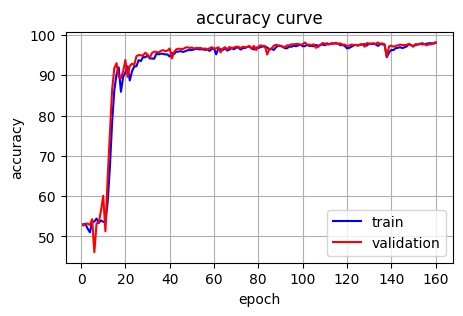

In [22]:
# draw accuracy curve
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.plot(counter[:last_epoch_number], train_accuracy_history[:last_epoch_number], marker='', c='blue', label="train")
plt.plot(counter[:last_epoch_number], valid_accuracy_history[:last_epoch_number], marker='', c='red', label="validation")

plt.legend(loc='lower right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy curve')
plt.savefig('result{}_accuracy_curve.png'.format(result_number), bbox_inches='tight')
plt.show()

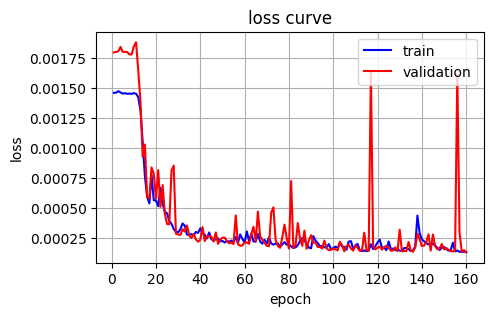

In [23]:
# draw loss curve
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.plot(counter[:last_epoch_number], train_loss_history[:last_epoch_number], marker='', c='blue', label="train")
plt.plot(counter[:last_epoch_number], valid_loss_history[:last_epoch_number], marker='', c='red', label="validation")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss curve')
plt.savefig('result{}_loss_curve.png'.format(result_number), bbox_inches='tight')
plt.show()

In [24]:
# 모델 저장 및 불러오기
torch.save(model, './result{}.pth'.format(result_number))
# model = torch.load('./result{}.pth'.format(result_number)).to(device)

### **Test**

In [25]:
class TestDataset(Dataset):
    def __init__(self, Config):
        self.dir = Config.test_data_dir
        self.data_list = os.listdir(self.dir)
        self.label_df = pd.read_csv(Config.test_df_dir)
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        label_list = list()
        file_name = self.data_list[idx]
        file_dir = self.dir + file_name
        mfccs, features = extract_features(file_dir)
        
        mfccs = torch.tensor(mfccs).to(torch.float32).unsqueeze(0)
        features = torch.tensor(features).to(torch.float32).unsqueeze(0)
        
        if self.label_df[self.label_df['file']==file_name]['label'].item() == 'nonscream':
            label_list.append(0)
        else: label_list.append(1)
        
        label = torch.tensor(label_list)
        
        return mfccs, features, label, file_name

In [26]:
# define test dataset and dataloader
test_dataset = TestDataset(Config())
test_dataloader = DataLoader(test_dataset, batch_size=164, shuffle=False)

In [27]:
# evaluate the model with test dataset
# extract features from test files directly, which differs from training session. 
model.eval()
correct = 0
total = 0
wrong_files_list = list()
preds_list = list()
label_list = list()

with torch.inference_mode():
    for i, (mfccs, features, label, file_name) in enumerate(test_dataloader):
        mfccs = mfccs.to(device)
        features = features.to(device)
        label = label.to(device)
        
        outputs = model(mfccs, features)
        preds = outputs.round()
        loss = loss_fn(outputs.to(torch.float32), label.to(torch.float32))
        
        total += label.size(0)
        correct += (preds == label).sum().item()
        
        # make wrong prediction file names list using np.array mask.
        wrong_mask = preds != label
        wrong_mask = np.array(wrong_mask.squeeze(-1).cpu())
        file_name = np.array(file_name)
        wrong_files = file_name[wrong_mask].tolist()
        
        preds_list += preds.squeeze(-1).to(torch.int8).tolist()
        label_list += label.squeeze(-1).to(torch.int8).tolist()
        wrong_files_list += wrong_files
        
        clean()

print('correct / total : {} / {}'.format(correct, total))
print('accuracy : {:.4f}%'.format(100*correct/total))
print(wrong_files_list)

correct / total : 160 / 164
accuracy : 97.5610%
['00073.wav', '00092.wav', '00111.wav', '00112.wav']


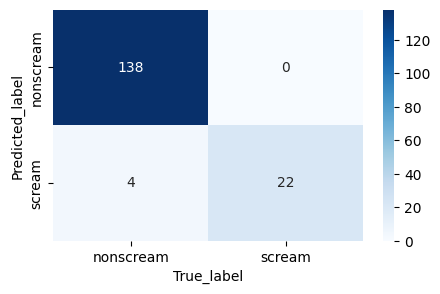

In [28]:
# plot confusion matrix
import seaborn as sns
from sklearn import metrics
cm = metrics.confusion_matrix(preds_list, label_list)
df_cm = pd.DataFrame(data=cm, columns=['nonscream', 'scream'],
                     index=['nonscream', 'scream'])
plt.figure(figsize=(5, 3))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues'
            ).set(xlabel="True_label", ylabel="Predicted_label")
plt.savefig('result{}_confusion_matrix.png'.format(result_number), bbox_inches='tight')